### Figure SI - Data analysis

**Author:** Quentin Duez

This notebook analyses ESI-MS data and extracts relative time delays and amplitudes of propagating perturbations for the experiment involving p-OMe cinnamaldehyde.

**Outputs:** Figure S6

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

sns.set_theme(style="ticks", context="paper")

TIMEBIN = 15  # ~1bin = 30s
Ald_conc = 5  # mM
Cat_conc = 2  # mM
Cyclo_conc = 250  # mM

In [2]:
# Fitting functions


def sinfunc(t, A, w, p, c):
    return A * np.sin(np.pi * (t - p) / w) + c
    # return A * np.sin(w*t + p) + c


def fit_sin(
    tt, yy, PERIOD
):  # Scooped from https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    # guess_freq = 1./ PERIOD
    # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.0**0.5
    guess_offset = np.mean(yy)
    guess = np.array(
        [guess_amp, PERIOD / 2, 0.0, guess_offset]
    )  # Guess phase = 0; check what works better

    popt, pcov = curve_fit(
        sinfunc,
        tt,
        yy,
        p0=guess,
        bounds=(
            (0, (PERIOD - 0.0001) / 2, -np.inf, -np.inf),
            (np.inf, (PERIOD + 0.0001) / 2, np.inf, np.inf),
        ),
    )
    A, w, p, c = popt
    f = w / (2.0 * np.pi)
    period = w * 2
    fitfunc = lambda t: A * np.sin(np.pi * (t - p) / w) + c
    return {
        "amp": A,
        "omega": w,
        "phase": p,
        "offset": c,
        "freq": f,
        "period": period,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov),
    }


def fit_sin_CSTR(t, conc, eq_time, PERIOD):
    t_filtered = t[eq_time:]
    conc_filtered = conc[eq_time:]

    res = fit_sin(t_filtered, conc_filtered, PERIOD)
    ypred = sinfunc(t_filtered, res["amp"], res["omega"], res["phase"], res["offset"])
    r2 = r2_score(conc_filtered, ypred)
    # print(r2_score(conc_filtered, ypred))
    phase = res["phase"]
    amp = res["amp"]

    if abs(phase) > PERIOD:
        ntot = abs(phase) / PERIOD
        nunits = ntot // 1
        if nunits > 0:
            coma = ntot - nunits
        else:
            coma = 0
        phase = coma * PERIOD
    else:
        phase = phase

    if r2 > 0.2:  # Condition for not trying to interpret weird data
        rel_amp = (
            abs(res["amp"]) / res["offset"]
        )  # Calculate the amplitude of the oscillation relative to the ion signal

        # Get time delay from the phase (empirically determined, was tricky for me brain)
        if (res["amp"] > 0) & (phase > 0):
            delay = phase + 0.5 * res["omega"]
        elif (res["amp"] > 0) & (phase < 0):
            delay = phase + 2.5 * res["omega"]
        else:
            pass
    else:
        rel_amp = 0
        delay = 0
        phase = 0

    return (rel_amp, delay, r2, phase, amp)

In [3]:
# Reading flow profile
profile = pd.read_excel("data/250219_Iminium07.xlsx")
profile = profile.iloc[
    :, : profile.columns.get_loc("Concentration")
]  # Dropping everything after "Concentration"
profile = profile.iloc[
    :, profile.columns.get_loc("Flow") + 1 :
]  # Dropping everything before "Flow"
profile = profile.drop(columns=["Time"])
profile.set_index("Cumul. Time", inplace=True)
profile["Aldehyde_conc"] = (profile["Aldehyde"] * Ald_conc) / profile.sum(axis=1)
profile["Aldehyde_conc_rel"] = (
    profile["Aldehyde_conc"] / profile["Aldehyde_conc"].mean()
)
profile = profile.dropna()

profile.index = profile.index - 540

print(profile)

             Aldehyde  Catalyst  Cyclopentadiene     MeOH1     MeOH2  \
Cumul. Time                                                            
-540.0       5.766600    5.7666           5.7666  5.766767  5.766767   
-390.0       5.766600    5.7666           5.7666  5.766767  5.766767   
-389.9       5.826987    5.7666           5.7666  5.736573  5.736573   
-389.8       5.887367    5.7666           5.7666  5.706383  5.706383   
-389.7       5.947733    5.7666           5.7666  5.676200  5.676200   
...               ...       ...              ...       ...       ...   
 1049.6      5.284063    5.7666           5.7666  6.008035  6.008035   
 1049.7      5.404512    5.7666           5.7666  5.947811  5.947811   
 1049.8      5.525120    5.7666           5.7666  5.887507  5.887507   
 1049.9      5.645833    5.7666           5.7666  5.827150  5.827150   
 1050.0      5.766600    5.7666           5.7666  5.766767  5.766767   

             Aldehyde_conc  Aldehyde_conc_rel  
Cumul. Time    

In [4]:
# Reading data
data = pd.read_excel("data/250219_Iminium07_Data.xlsx", header=0)

data["185_TIC"] = data["IC_185"] / data["TIC"]
data["326_TIC"] = (
    data["IC_326"] / data["TIC"]
)  # 326 was saturating a bit, we will not use it
data["470_TIC"] = data["IC_470"] / data["TIC"]
data["536_TIC"] = data["IC_536"] / data["TIC"]
data["651_TIC"] = (
    data["IC_651"] / data["TIC"]
)  # 651 could be the product (although super low intensity)

bindata = data.groupby(data.index // TIMEBIN).mean()
bindata = bindata.drop(columns=["TIC"])
bindata.set_index("Time", inplace=True)

rolled_bindata = bindata.rolling(5, center=True).mean()

print(bindata)

                   IC_185        IC_326        IC_470        IC_536  \
Time                                                                  
0.267733     7.846233e+04  1.528594e+05  1.344802e+05  1.452565e+05   
0.770667     1.414839e+06  2.832000e+06  5.735745e+06  3.585751e+05   
1.273267     7.487693e+04  1.486841e+05  1.429752e+05  1.337968e+05   
1.776267     7.656653e+04  1.493960e+05  1.468656e+05  1.578793e+05   
2.278933     9.190133e+04  1.440379e+05  1.453299e+05  1.482325e+05   
...                   ...           ...           ...           ...   
1698.241200  6.717874e+07  8.927782e+08  4.861504e+08  5.114118e+07   
1698.744000  7.869219e+07  8.276739e+08  5.144317e+08  6.301271e+07   
1699.246733  7.870365e+07  7.870322e+08  4.970477e+08  6.164197e+07   
1699.749667  8.280430e+07  8.923011e+08  4.843252e+08  6.984795e+07   
1700.018000  1.472589e+08  5.604413e+08  4.988656e+08  3.316664e+07   

                    IC_251        IC_651   185_TIC   326_TIC   470_TIC  \
Ti

In [5]:
data_2ndosci = bindata[(bindata.index > 540) & (bindata.index < 1410)]
data_2ndosci["185_TIC_rel"] = data_2ndosci["185_TIC"] / data_2ndosci["185_TIC"].mean()
data_2ndosci["326_TIC_rel"] = data_2ndosci["326_TIC"] / data_2ndosci["326_TIC"].mean()
data_2ndosci["470_TIC_rel"] = data_2ndosci["470_TIC"] / data_2ndosci["470_TIC"].mean()
data_2ndosci["536_TIC_rel"] = data_2ndosci["536_TIC"] / data_2ndosci["536_TIC"].mean()
data_2ndosci["651_TIC_rel"] = data_2ndosci["651_TIC"] / data_2ndosci["651_TIC"].mean()
rolled_data_2ndosci = data_2ndosci.rolling(5, center=True).mean()
rolled_data_2ndosci = rolled_data_2ndosci.dropna()

data_2ndosci.index = data_2ndosci.index - 540
rolled_data_2ndosci.index = rolled_data_2ndosci.index - 540
profile_2ndosci = profile[(profile.index > 0) & (profile.index < 900)]

C:\Users\qduez\AppData\Local\Temp\ipykernel_7584\4175144995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2ndosci["185_TIC_rel"] = data_2ndosci["185_TIC"] / data_2ndosci["185_TIC"].mean()
C:\Users\qduez\AppData\Local\Temp\ipykernel_7584\4175144995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2ndosci["326_TIC_rel"] = data_2ndosci["326_TIC"] / data_2ndosci["326_TIC"].mean()
C:\Users\qduez\AppData\Local\Temp\ipykernel_7584\4175144995.py:4: SettingWithCopyWarning: 
A value is trying to be

185 (0.10195118992507847, 119.16054400598762, 0.4891770448345505)
470 (0.30109390718172185, 115.05957193057259, 0.6550564576579776)
536 (0.16420992982218618, 137.85076650509515, 0.5594909807051808)
651 (0.10663223586526328, 57.31539391126701, 0.6183200920411782)


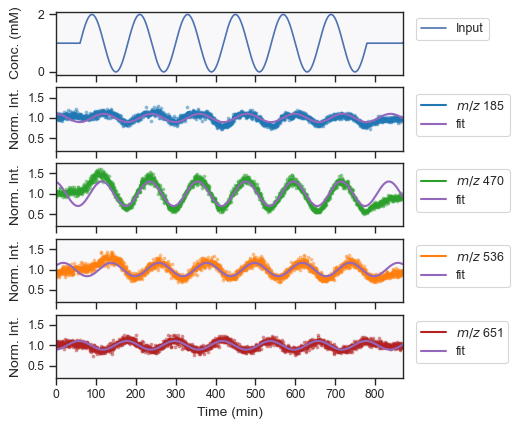

In [6]:
fig, ax = plt.subplots(5, 1, figsize=(7.3, 3.7))

sns.lineplot(
    data=profile, x=profile.index, y="Aldehyde_conc_rel", ax=ax[0], label="Input"
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="185_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[1],
    c="tab:blue",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="185_TIC_rel",
    ax=ax[1],
    linewidth=1.5,
    label=r"$\it{m/z}$ 185",
    c="tab:blue",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="470_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[2],
    c="tab:green",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="470_TIC_rel",
    ax=ax[2],
    linewidth=1.5,
    label=r"$\it{m/z}$ 470",
    c="tab:green",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="536_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[3],
    c="tab:orange",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="536_TIC_rel",
    ax=ax[3],
    linewidth=1.5,
    label=r"$\it{m/z}$ 536",
    c="tab:orange",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="651_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[4],
    c="firebrick",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="651_TIC_rel",
    ax=ax[4],
    linewidth=1.5,
    label=r"$\it{m/z}$ 651",
    c="firebrick",
)

ax[0].set_xlim(0, 870)
ax[1].set_xlim(0, 870)
ax[2].set_xlim(0, 870)
ax[3].set_xlim(0, 870)
ax[4].set_xlim(0, 870)
ax[1].set_ylim(0.2, 1.75)
ax[2].set_ylim(0.2, 1.75)
ax[3].set_ylim(0.2, 1.75)
ax[4].set_ylim(0.2, 1.75)

ax[0].set_ylabel("Conc. (mM)", fontsize=10)
ax[1].set_ylabel("Norm. Int.", fontsize=10)
ax[2].set_ylabel("Norm. Int.", fontsize=10)
ax[3].set_ylabel("Norm. Int.", fontsize=10)
ax[4].set_ylabel("Norm. Int.", fontsize=10)

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")
ax[3].set_xlabel("")
ax[4].set_xlabel("Time (min)", fontsize=10)

ax[0].set_xticklabels("")
ax[1].set_xticklabels("")
ax[2].set_xticklabels("")
ax[3].set_xticklabels("")


fit_185 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["185_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_470 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["470_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_536 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["536_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_651 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["651_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time

pred_185 = sinfunc(data_2ndosci.index.to_numpy(), fit_185[4], 60, fit_185[3], 1)
pred_470 = sinfunc(data_2ndosci.index.to_numpy(), fit_470[4], 60, fit_470[3], 1)
pred_536 = sinfunc(data_2ndosci.index.to_numpy(), fit_536[4], 60, fit_536[3], 1)
pred_651 = sinfunc(data_2ndosci.index.to_numpy(), fit_651[4], 60, fit_651[3], 1)

# Uncomment to plot the fitted sinewaves
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_185,
    ax=ax[1],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_470,
    ax=ax[2],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_536,
    ax=ax[3],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_651,
    ax=ax[4],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)

ax[0].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[1].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[2].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[3].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[4].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)

ax[0].set_facecolor("#F8F8FB")
ax[1].set_facecolor("#F8F8FB")
ax[2].set_facecolor("#F8F8FB")
ax[3].set_facecolor("#F8F8FB")
ax[4].set_facecolor("#F8F8FB")

print("185", fit_185[0:3])
print("470", fit_470[0:3])
print("536", fit_536[0:3])
print("651", fit_651[0:3])

fig.align_ylabels(ax[:])

plt.subplots_adjust(left=None, bottom=None, right=0.6, top=1.1, wspace=None, hspace=0.2)
# plt.savefig('FigureSI_OMe.svg', format='svg', bbox_inches='tight', dpi=600)